https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-strategies/nirspec-msata-reference-star-selection-recommended-strategies

need ~25 reference objects over the entire MSA, of which ~25% will likely be usable, yielding the ~6 we need.

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
from glob import glob
from os.path import join
from os.path import expanduser
home = expanduser("~")

#from astropy.io import ascii
import astropy
from astropy.table import Table, vstack
import astropy.units as u

In [3]:
from PIL import Image, ImageEnhance
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # avoid decompression bomb error when loading large images

In [4]:
def roundint(x):
    return int(np.round(x))

def between(lo, x, hi):
    return (lo < x) * (x < hi)

# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

def extract_id(cat, id, idlabel='id'):
    # Note input id must be same format as cat[idlabel] (int or string)
    # to create an array with mostly False entries and True for id
    # cat['id'] dtype='int64'
    # cat['id'] == 3: [False, False, True, False...]
    # cat['id'] == '3': False
    #
    # obj:          astropy.table.table.Table
    # obj[0]:       astropy.table.row.Row
    # obj['id']:    astropy.table.column.Column
    # obj[0]['id']: numpy.int64
    duck_duck_goose = cat[idlabel] == int(id)
    if len(duck_duck_goose):
        obj = cat[duck_duck_goose]
    return obj[0]

In [5]:
field = 'macs0647'
#indir = '../eazy_v4'
#indir = '../catalogs'
indir  = os.path.join(home, field, 'catalogs')
infile = field + '_phot-eazy.ecsv'
infile = os.path.join(indir, infile)

catalog = astropy.io.ascii.read(infile)
catalog[:2]

<Table length=2>
  id      ra        dec            x                 y           z_spec ...   rest414    rest414_err    rest415    rest415_err    rest416    rest416_err 
                                                                        ...                                                                              
int32  float64    float64       float64           float64       float64 ...   float32      float32      float32      float32      float32      float32   
----- ---------- --------- ----------------- ------------------ ------- ... ------------ ------------ ------------ ------------ ------------ ------------
    1 102.015220 70.161446 4098.274752800464  1.999824071826548    -1.0 ...      -99.000        0.000      -99.000        0.000      -99.000        0.000
    2 101.948789 70.161459 8156.305414383205 1.9979236794378306    -1.0 ...      -99.000        0.000      -99.000        0.000      -99.000        0.000

In [6]:
# Forgot flux_radius
inroot = field + '-grizli-v4.0'
catalog_file = inroot + '_phot.fits.gz'
catalog_file = os.path.join(indir, catalog_file)
eazy_phot = Table.read(catalog_file)
eazy_phot[:2]

<Table length=2>
  id          thresh         npix tnpix  xmin  xmax ... f850lp_fluxerr_aper_6 f850lp_flag_aper_6 f850lp_bkg_aper_6 f850lp_mask_aper_6  f850lp_tot_corr 
                                                    ...          uJy                                    uJy                                            
int32        float64        int64 int64 int64 int64 ...        float64              int16             float64           float64            float64     
----- --------------------- ----- ----- ----- ----- ... --------------------- ------------------ ----------------- ------------------ -----------------
    1 1.500000098129063e+30 11769     0    21  3943 ...                    --                 48                -- 2321.3957350059095 1.026797609171861
    2 1.500000098129063e+30   504     0  3984  4151 ...                    --                 48                --  2321.324527481465 1.145360906402689

In [7]:
len(catalog), len(eazy_phot)

(5500, 5500)

In [8]:
catalog['flux_radius'] = eazy_phot['flux_radius']

In [9]:
catalog['fwhm'] = 2 * catalog['flux_radius'] * 0.02

In [10]:
# Reconstitute filters
filters = []
for label in catalog.columns:
    if label.endswith('_flux'):
        filters.append(label[:-5])
        
#filters

In [11]:
# flux -> mag

flux_units = u.uJy

for filt in filters:
    label = filt + '_flux'
    flux = catalog[filt+'_flux']
    fluxerr = catalog[filt+'_fluxerr']
    #flux = flux.to(u.uJy).value
    #fluxerr = fluxerr.to(u.uJy).value
    nan_flux = np.isnan(flux)
    flux = np.where(nan_flux, 0, flux)
    fluxerr = np.where(nan_flux, 1e30, fluxerr)
    mag, magerr = fluxes2mags(flux * flux_units, fluxerr * flux_units)
    #mag, magerr = fluxes2mags(flux, fluxerr)
    #cat[filt+'_flux'] = flux
    #cat[filt+'_fluxerr'] = fluxerr
    catalog[filt+'_mag'] = mag.value
    catalog[filt+'_magerr'] = magerr.value

/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [12]:
catalog[:2]

<Table length=2>
  id      ra        dec            x                 y           z_spec f105w_flux ... f775w_mag f775w_magerr f814w_mag f814w_magerr f850lp_mag f850lp_magerr
                                                                                   ...                                                                       
int32  float64    float64       float64           float64       float64  float32   ...  float32    float32     float32    float32     float32      float32   
----- ---------- --------- ----------------- ------------------ ------- ---------- ... --------- ------------ --------- ------------ ---------- -------------
    1 102.015220 70.161446 4098.274752800464  1.999824071826548    -1.0    -99.000 ...     -99.0          0.0     -99.0          0.0      -99.0           0.0
    2 101.948789 70.161459 8156.305414383205 1.9979236794378306    -1.0    -99.000 ...     -99.0          0.0     -99.0          0.0      -99.0           0.0

In [13]:
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
import astropy.wcs as wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [14]:
#image_dir = '../images/grizli_v4/20mas'
#image_file = 'sunrise-grizli-v4.0-f200w-clear_drc_sci.fits.gz'
#image_dir = '../images/20mas'
image_dir = os.path.join(home, 'macs0647', 'images', '20mas')
image_file = 'macs0647-grizli-v4.0-f444w-clear_20mas_sci.fits.gz'
image_file = os.path.join(image_dir, image_file)
hdu = fits.open(image_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 101.9482378  70.2297032  
CRPIX : 8191.5  12287.5  
CD1_1 CD1_2  : -5.5555555555555e-06  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555555e-06  
NAXIS : 16384  24576

In [15]:
catalog_coordinates = SkyCoord(ra=catalog['ra']*u.deg, dec=catalog['dec']*u.deg)  # *u.deg
catalog['x'], catalog['y'] = image_wcs.world_to_pixel(catalog_coordinates)
catalog[:2]

<Table length=2>
  id      ra        dec            x                 y           z_spec f105w_flux ... f775w_mag f775w_magerr f814w_mag f814w_magerr f850lp_mag f850lp_magerr
                                                                                   ...                                                                       
int32  float64    float64       float64           float64       float64  float32   ...  float32    float32     float32    float32     float32      float32   
----- ---------- --------- ----------------- ------------------ ------- ---------- ... --------- ------------ --------- ------------ ---------- -------------
    1 102.015220 70.161446 4098.774752798645 2.4998240633267415    -1.0    -99.000 ...     -99.0          0.0     -99.0          0.0      -99.0           0.0
    2 101.948789 70.161459 8156.805414383232 2.4979236762319488    -1.0    -99.000 ...     -99.0          0.0     -99.0          0.0      -99.0           0.0

In [16]:
catalog['flux'] = eazy_phot['flux']
catalog['peak'] = eazy_phot['peak']

In [17]:
#mycat = catalog[between(0, catalog['f115w_mag'], 90)]  # F110W
mycat = catalog[between(0, catalog['f150w_mag'], 90)]  # F140X

In [18]:
len(mycat)

4796

<IPython.core.display.Javascript object>


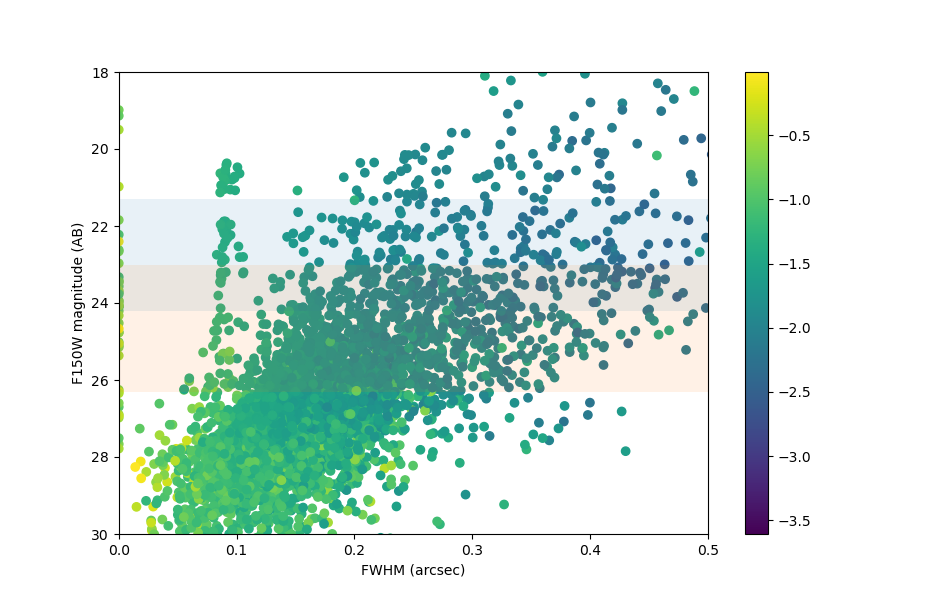

Text(0, 0.5, 'F150W magnitude (AB)')

In [19]:
fig = plt.figure(figsize=(9.5,6))
#plt.plot(mycat['fwhm'], mycat['f110w_mag'], 'o')
#plt.scatter(mycat['fwhm'], mycat['f110w_mag'], c=mycat['stel'])
c = np.log10(mycat['peak'] / mycat['flux'])
#plt.scatter(0.02*mycat['flux_radius'], mycat['f115w_mag'], c=c)
plt.scatter(mycat['fwhm'], mycat['f150w_mag'], c=c)
#plt.fill_between([0, 1], 19.5, 22, alpha=0.1)  JDox v1.0 F110W NRSRAPID
#plt.fill_between([0, 1], 21.3, 24, alpha=0.1)  JDox v1.0 F110W NRSRAPID6
#plt.fill_between([0, 1], 20.3, 23.2, alpha=0.1)  # JDox v1.2 F110W NRSRAPID
#plt.fill_between([0, 1], 22.0, 25.3, alpha=0.1)  # JDox v1.2 F110W NRSRAPID6
plt.fill_between([0, 1], 21.3, 24.2, alpha=0.1)  # JDox v1.2 F140X NRSRAPID
plt.fill_between([0, 1], 23.0, 26.3, alpha=0.1)  # JDox v1.2 F140X NRSRAPID6
plt.colorbar()
#plt.colorbar(label='Stellarity')
plt.ylim(plt.ylim()[::-1])
#plt.xlim(0,1)
plt.xlim(0,0.5)
plt.ylim(30,18)
plt.xlabel('FWHM (arcsec)')
#plt.xlabel('Flux Radius (arcsec)')
#plt.ylabel('F115W magnitude (AB)')
plt.ylabel('F150W magnitude (AB)')

# Try *not* clipping magnitudes; I *think* APT does this

In [20]:
#good_mag = between(21.3, mycat['f115w_mag'], 24)
#good_mag = between(21.3, mycat['f150w_mag'], 24.2)
#good_mag = between(21.6, mycat['f150w_mag'], 24.2)  # not too close to saturation
#compact = mycat['fwhm'] < 0.2
#compact = between(0, mycat['fwhm'], 0.2)

#good_mag = mycat['f150w_mag'] < 26.5  # all of them
#compact = between(0, mycat['fwhm'], 0.11)  # tighter

good_mag = mycat['f150w_mag'] < 26.3  # all of them
#compact = between(0.11, mycat['fwhm'], 0.15)  # tighter -- what's left
#compact = between(0, mycat['fwhm'], 0.15)  # tighter
compact = between(0.15, mycat['fwhm'], 0.17)  # tighter -- what's left
compact = between(0, mycat['fwhm'], 0.17)  # tighter
compact = between(0, mycat['fwhm'], 0.11)

# Less is more
good_mag = between(21.6, mycat['f150w_mag'], 24.2)  # not too close to saturation
#compact = between(0, mycat['fwhm'], 0.11) # not enough?
compact = between(0, mycat['fwhm'], 0.15)

In [21]:
good = good_mag * compact

In [22]:
len(mycat[good]), len(mycat)

(43, 4796)

In [23]:
good_cat = mycat[good]

In [24]:
d_bright = 3.2 * u.arcsec
#within_box = distances < d_bright
#cat_coordinates[within_box]

In [25]:
pixel_scale = 0.02 * u.arcsec
d = d_bright / pixel_scale
d /= 2  # 3.2" x 3.2"
d = roundint(d)
d

80

In [26]:
good_cat.sort('fwhm')

<IPython.core.display.Javascript object>


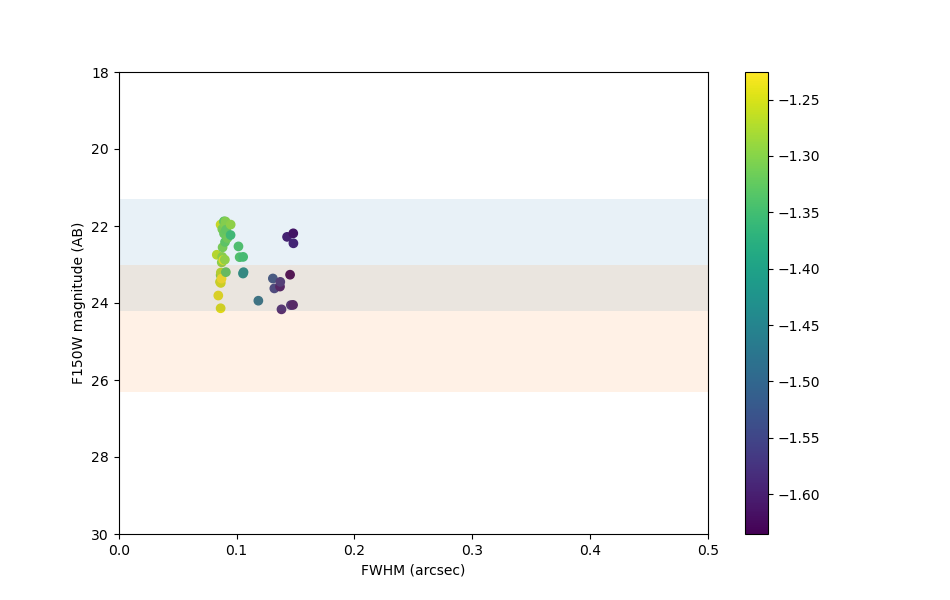

Text(0, 0.5, 'F150W magnitude (AB)')

In [27]:
fig = plt.figure(figsize=(9.5,6))
c = np.log10(good_cat['peak'] / good_cat['flux'])
plt.scatter(good_cat['fwhm'], good_cat['f150w_mag'], c=c)
#plt.fill_between([0, 1], 19.5, 22, alpha=0.1)  JDox v1.0 F110W NRSRAPID
#plt.fill_between([0, 1], 21.3, 24, alpha=0.1)  JDox v1.0 F110W NRSRAPID6
#plt.fill_between([0, 1], 20.3, 23.2, alpha=0.1)  # JDox v1.2 F110W NRSRAPID
#plt.fill_between([0, 1], 22.0, 25.3, alpha=0.1)  # JDox v1.2 F110W NRSRAPID6
plt.fill_between([0, 1], 21.3, 24.2, alpha=0.1)  # JDox v1.2 F140X NRSRAPID
plt.fill_between([0, 1], 23.0, 26.3, alpha=0.1)  # JDox v1.2 F140X NRSRAPID6
plt.colorbar()
plt.ylim(plt.ylim()[::-1])
plt.xlim(0,0.5)
plt.ylim(30,18)
plt.xlabel('FWHM (arcsec)')
#plt.xlabel('Flux Radius (arcsec)')
#plt.ylabel('F115W magnitude (AB)')
plt.ylabel('F150W magnitude (AB)')

# Inspect color images

In [28]:
#infile = '/Users/dcoe/RELICS/data/whl0137-08/epoch4/color/whl0137-08_new_bright.png' # HST
#infile = '/Users/dcoe/RELICS/data/whl0137-08/JWST/color/whl0137_v4_bright.png'
infile = field + '_color_sw.png'
indir = os.path.join(home, field, 'color')
infile = os.path.join(indir, infile)
im = Image.open(infile)
imrgb = np.asarray(im)
imrgb = imrgb[::-1]

In [29]:
good_cat.sort('f150w_mag')

<IPython.core.display.Javascript object>


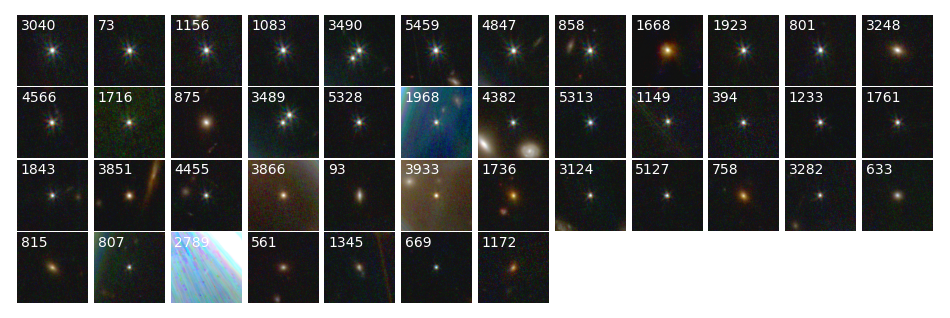

In [30]:
n = len(good_cat)
ncolumns = 12
nrows = np.ceil(n / ncolumns).astype(int)

fig_width = 9.5
fig_height = 8.8 * nrows / 7. * 9.5 / 15.

fig, ax = plt.subplots(nrows, ncolumns, figsize=(fig_width,fig_height))
ax = ax.flatten()

for i in range(ncolumns*nrows):
    ax[i].axis('off')
    
for i in range(n):
    x = roundint(good_cat['x'][i])
    y = roundint(good_cat['y'][i])
    extent = x-d-0.5, x+d+0.5, y-d-0.5, y+d+0.5
    ax[i].imshow(imrgb[y-d:y+d+1,x-d:x+d+1], origin='lower', extent=extent)
    ax[i].text(x-0.9*d,y+0.9*d, good_cat['id'][i], va='top', color='white')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02)

In [31]:
good_cat_coordinates = SkyCoord(ra=good_cat['ra']*u.degree, dec=good_cat['dec']*u.degree)

In [32]:
d_bright = 3.2 * u.arcsec  # avoid brighter comapnions within 3.2"
d_faint  = 0.3 * u.arcsec  # avoid fainter  companions within 0.3"

In [33]:
brightest_in_big_box = np.ones(n)
alone_in_small_box   = np.ones(n)
mag = good_cat['f150w_mag']

for i in range(len(good_cat)):
    obj_coordinates = SkyCoord(ra=good_cat['ra'][i]*u.degree, dec=good_cat['dec'][i]*u.degree)
    distances = obj_coordinates.separation(good_cat_coordinates)
    
    within_box = distances < d_bright
    within_box = within_box * (distances > 0)  # exclude self (distance = 0)
    idxcatalog = np.where(within_box)[0]
    if np.any(within_box):
        brightest_in_big_box[i] = mag[i] < np.min(mag[idxcatalog])
    
    within_small_box = distances < d_faint
    within_small_box = within_small_box * (distances > 0)  # exclude self (distance = 0)    
    if np.any(within_small_box):
        alone_in_small_box[i] = False
        
    #print(i, '%.2f' % mag[i], brightest_in_big_box[i], alone_in_small_box[i])

In [34]:
all_good = brightest_in_big_box * alone_in_small_box

In [35]:
np.sum(brightest_in_big_box), np.sum(alone_in_small_box), np.sum(all_good), len(all_good)

(40.0, 43.0, 40.0, 43)

In [36]:
good_star_cat = good_cat[all_good.astype(bool)]

<IPython.core.display.Javascript object>


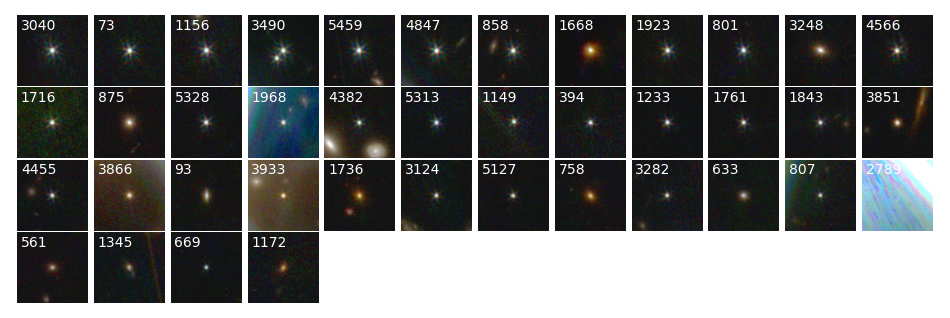

In [37]:
n = len(good_star_cat)
ncolumns = 12
nrows = np.ceil(n / ncolumns).astype(int)

fig_width = 9.5
fig_height = 8.8 * nrows / 7. * 9.5 / 15.

fig, ax = plt.subplots(nrows, ncolumns, figsize=(fig_width,fig_height))
ax = ax.flatten()

for i in range(ncolumns*nrows):
    ax[i].axis('off')
    
for i in range(n):
    x = roundint(good_star_cat['x'][i])
    y = roundint(good_star_cat['y'][i])
    extent = x-d-0.5, x+d+0.5, y-d-0.5, y+d+0.5
    ax[i].imshow(imrgb[y-d:y+d+1,x-d:x+d+1], origin='lower', extent=extent)
    ax[i].text(x-0.9*d,y+0.9*d, good_star_cat['id'][i], va='top', color='white')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02)

In [38]:
plt.savefig(field+'_reference_object_candidates.png')
#plt.savefig(field+'_reference_object_candidates_fwhm01517.png')

# Manually prune 

avoid anything brighter in box and any close companion

In [39]:
good_star_cat = good_cat[all_good.astype(bool)]  # redo this in case you need to redo that below

In [40]:
# 3767 -- extended: Tony Keyes -- interesting; it looks like a star...
#bad_ids = 3490, 3489, 21, 3525, 3124, 3767, 4363, 1968, 2789, 389, 4532, 1770, 2683
bad_ids = 3490, 3489, 21, 3525, 3124, 3767, 4363, 1968, 2789, 389, 4532, 1770, 2683, 2248, 2584, 2793, 2497, 3603,\
3899, 2317, 1648, 2197, 2217, 2205, 3925, 3992,\
2789, 2097, 2893, 5481, 1348, 2299, 1016, 2202, 2087, 2920, 3174, 899, 3277, 2515, 2632, 439, 1645, 4690, 1459, \
3947, 4805, 30, 1742, 926, 3483, 1813, 1460, 136, 1036, 3456, 4106, 2237, 4641, 2146, \
389, 4532, 4898, 1037, 2108, 1664, 1210, 1277, 2201, 3219, 1752, 4009, 544, 1944, 1297, 2846, 4323, 1073, 5380, \
2843, 1630, 1925, 3090, 2377, 1734, 704, 717, 1647, 1445, 3615, 266, 4826, 5077, 2578, 5394, 3998, \
338, 3215, 2751, 470, 1169, 4059
# 2097 + 1016 = lensed multiple images?
#bad_ids

In [41]:
good_ids = list(set(good_star_cat['id']) - set(bad_ids))

In [42]:
#good_ids = 4613, 1745, 816, 170, 3632, 3885, 1649, 2056, 1195, 2170, 1442, 3078, 1251, 1569, 2498, 2776, 144, 693, 733, 1673, 5697, 631, 111, 1961, 4699, 2174, 3359, 238, 2575, 5704, 1981, 2755, 3599, 3687
#good_ids = 4613, 1745, 816, 170, 3710, 1901, 1621, 3632, 1026, 1084, 2341, 5606, 3885, 1649, 1740, 1045, 760, 4258, 2056, 1195, 4426, 2170, 1442, 3078, 1251, 1569, 2498, 2776, 144, 693, 3153, 433, 376, 3036, 733, 1673, 1648, 5463, 2745, 2252, 5697, 631, 5590, 4776, 111, 4908, 1961, 4699, 2174, 1540, 3359, 238, 2073, 2575, 1856, 5704, 2581, 1981, 4136, 2755, 1593, 2464, 3599, 985, 802, 3687

In [43]:
set(good_cat['id']) - set(good_ids)

{815, 1083, 1968, 2789, 3124, 3489, 3490}

In [44]:
set(good_ids) - set(good_cat['id'])  # Any typos?

set()

In [45]:
good_star_cat = catalog[np.array(good_ids) - 1]

In [46]:
#good_star_cat.sort('fwhm')
good_star_cat.sort('f150w_mag')

<IPython.core.display.Javascript object>


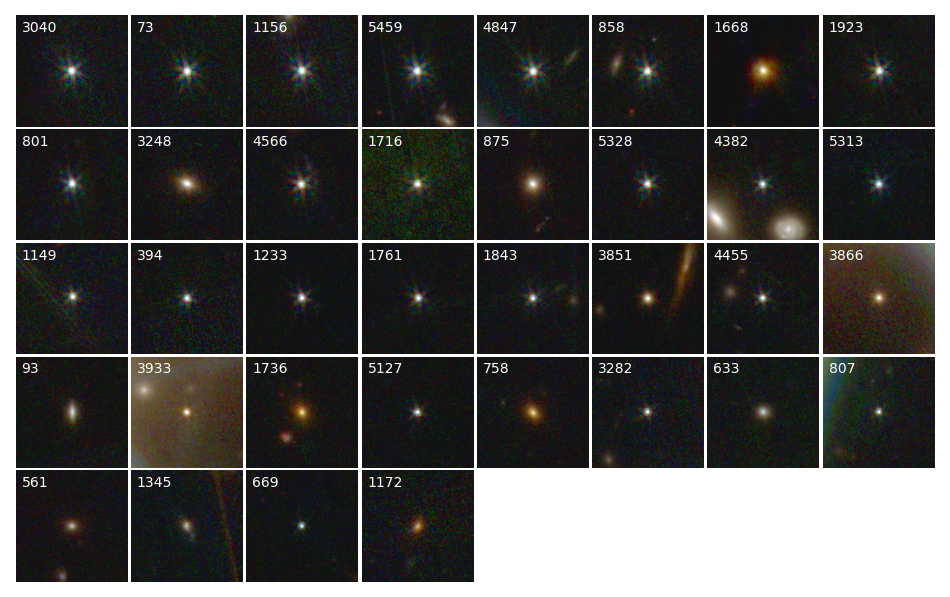

In [47]:
n = len(good_star_cat)
#ncolumns = 12
ncolumns = 8
nrows = np.ceil(n / ncolumns).astype(int)

fig_width = 9.5
fig_height = 8.8 * nrows / 7. * 9.5 / 15. * 12 / ncolumns

fig, ax = plt.subplots(nrows, ncolumns, figsize=(fig_width,fig_height))
ax = ax.flatten()

for i in range(ncolumns*nrows):
    ax[i].axis('off')
    
for i in range(n):
    x = roundint(good_star_cat['x'][i])
    y = roundint(good_star_cat['y'][i])
    extent = x-d-0.5, x+d+0.5, y-d-0.5, y+d+0.5
    ax[i].imshow(imrgb[y-d:y+d+1,x-d:x+d+1], origin='lower', extent=extent)
    ax[i].text(x-0.9*d,y+0.9*d, good_star_cat['id'][i], va='top', color='white')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02)

In [48]:
len(good_star_cat)

36

<IPython.core.display.Javascript object>


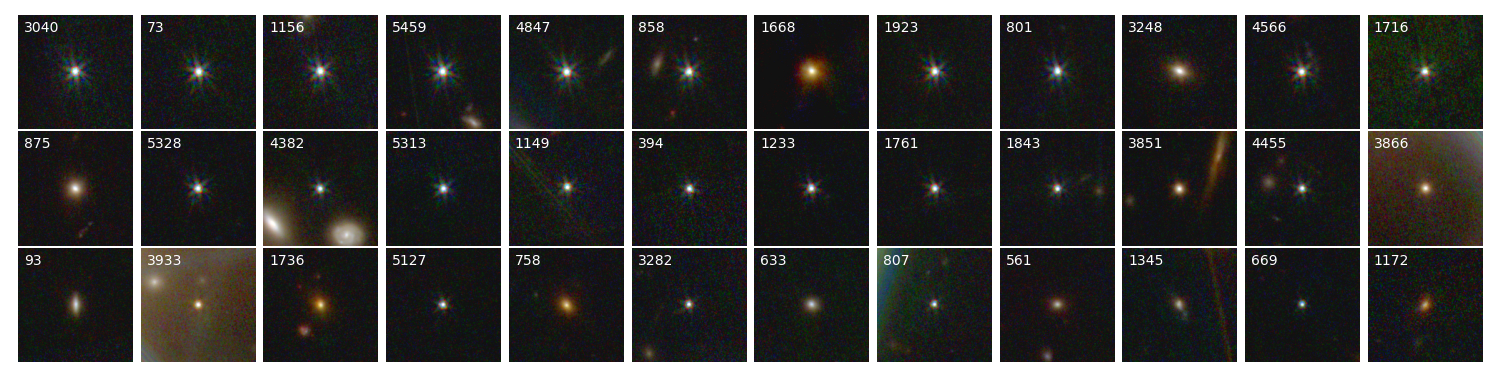

In [49]:
n = len(good_star_cat)
ncolumns = 12
nrows = np.ceil(n / ncolumns).astype(int)

fig_height = 6.3 * nrows / 5.

fig, ax = plt.subplots(nrows, ncolumns, figsize=(15,fig_height))
ax = ax.flatten()

for i in range(ncolumns*nrows):
    ax[i].axis('off')
    
for i in range(n):
    x = roundint(good_star_cat['x'][i])
    y = roundint(good_star_cat['y'][i])
    extent = x-d-0.5, x+d+0.5, y-d-0.5, y+d+0.5
    ax[i].imshow(imrgb[y-d:y+d+1,x-d:x+d+1], origin='lower', extent=extent)
    ax[i].text(x-0.9*d,y+0.9*d, good_star_cat['id'][i], va='top', color='white')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02)

In [50]:
plt.savefig(field+'_reference_objects_nircam.png')

In [51]:
#good_star_cat.write(field+'_reference_objects_nircam.cat', format='ascii.commented_header', delimiter=' ', overwrite=True)
good_star_cat.write(field+'_reference_objects_nircam.ecsv')

In [52]:
len(good_star_cat)

36

In [53]:
4207 in good_star_cat['id']

False

In [55]:
used_ids = 683, 758, 807, 1106, 1149, 1716, 1806, 3066
used_star_cat = catalog[np.array(used_ids) - 1]

<IPython.core.display.Javascript object>


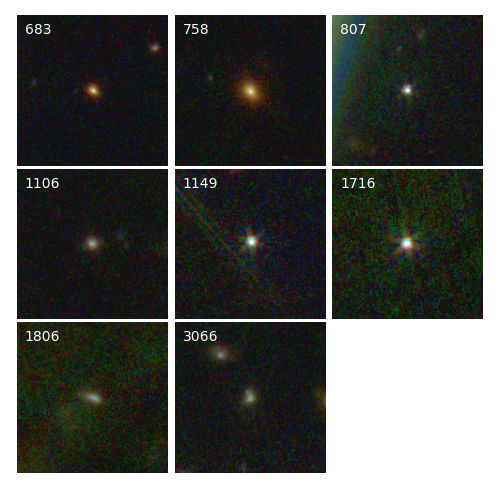

In [61]:
plot_cat = used_star_cat

n = len(plot_cat)
ncolumns = 3
nrows = np.ceil(n / ncolumns).astype(int)

fig_width = 5
fig_height = 18 * nrows / 7. * 9.5 / 15.

fig, ax = plt.subplots(nrows, ncolumns, figsize=(fig_width,fig_height))
ax = ax.flatten()

for i in range(ncolumns*nrows):
    ax[i].axis('off')
    
for i in range(n):
    x = roundint(plot_cat['x'][i])
    y = roundint(plot_cat['y'][i])
    extent = x-d-0.5, x+d+0.5, y-d-0.5, y+d+0.5
    ax[i].imshow(imrgb[y-d:y+d+1,x-d:x+d+1], origin='lower', extent=extent)
    ax[i].text(x-0.9*d,y+0.9*d, plot_cat['id'][i], va='top', color='white')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02)

plt.savefig('selected_reference_objects.png')